In [65]:
import numpy as np
import os
import cv2
from skimage.io import imread
from skimage.transform import resize
from skimage import img_as_ubyte
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from matplotlib import pyplot as plt

In [66]:
train_dataset = '/kaggle/input/ultrasound-breast-images-for-breast-cancer/ultrasound breast classification/train'
test_dataset = '/kaggle/input/ultrasound-breast-images-for-breast-cancer/ultrasound breast classification/val'

# Data Pre-Processing

In [67]:
for category in os.listdir(train_dataset):
    category_data = os.path.join(train_dataset, category)
    image_count = len(os.listdir(category_data))
    print(f'Number of images classified as {category}: ', image_count)

Number of images classified as benign:  4074
Number of images classified as malignant:  4042


In [68]:
for category in os.listdir(test_dataset):
    category_data = os.path.join(test_dataset, category)
    image_count = len(os.listdir(category_data))
    print(f'Number of images classified as {category}: ', image_count)

Number of images classified as benign:  500
Number of images classified as malignant:  400


In [69]:
mapping = {
    'benign': 0,
    'malignant': 1
}

In [70]:
IMAGE_SIZE = (224,224)

In [71]:
 def load_and_process_images(dataset_path):
    images = []
    labels = []
    for category in os.listdir(dataset_path):
        category_path = os.path.join(dataset_path, category)
        for image_filename in os.listdir(category_path):
            image_path = os.path.join(category_path, image_filename)
            image = imread(image_path, as_gray=True)
            image = resize(image, IMAGE_SIZE, anti_aliasing=True)

            # Convert image to uint8 (values between 0 and 255)
            image = img_as_ubyte(image)

            # Apply Median Blur for noise reduction
            image = cv2.medianBlur(image, 3)

            # Contrast stretching (normalize image to range 0-255)
            min_val, max_val = np.min(image), np.max(image)
            image = (image - min_val) / (max_val - min_val) * 255
            image = image.astype(np.uint8)  # Ensure type is uint8 for histogram equalization

            # Histogram equalization for enhancing the image
            image = cv2.equalizeHist(image)
            # Apply Sobel and Laplacian filters
            sobel_image = apply_sobel(image)
            laplacian_image = apply_laplacian(image)
            # Append processed data
            images.append(image.reshape(224, 224, 1))
            labels.append(mapping[category])

            # Visualize preprocessing steps for the first image only
            if len(images) == 1:
                plt.figure(figsize=(12, 6))
                plt.subplot(131)
                plt.imshow(image, cmap='gray')
                plt.title('Histogram Equalized Image')
                plt.subplot(132)
                plt.imshow(sobel_image, cmap='gray')
                plt.title('Sobel Filtered Image')
                plt.subplot(133)
                plt.imshow(laplacian_image, cmap='gray')
                plt.title('Laplacian Filtered Image')
                plt.show()
                plt.figure(figsize=(15, 5))
                plt.subplot(141)
                plt.hist(image.flatten(), 256, [0, 256], color='r')
                plt.title('Histogram for Equilized Image')
                plt.subplot(142)
                plt.hist(sobel_image.flatten(), 256, [0, 256], color='g')
                plt.title('Histogram for sobel')
                plt.subplot(143)
                plt.hist(laplacian_image.flatten(), 256, [0, 256], color='b')
                plt.title('Histogram for la placian Image')
                 
    return np.array(images), np.array(labels)

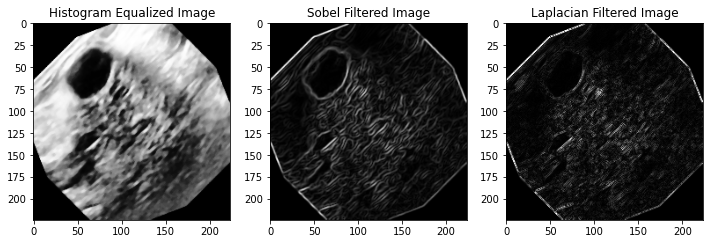

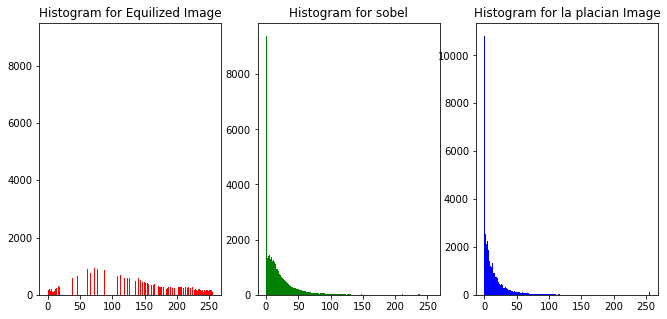

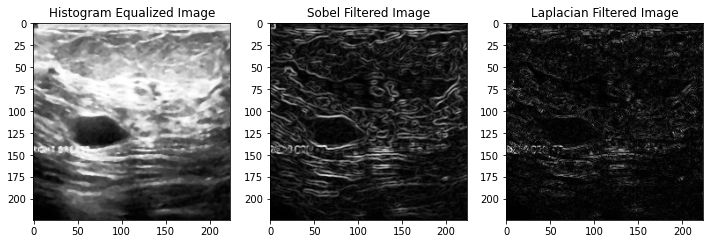

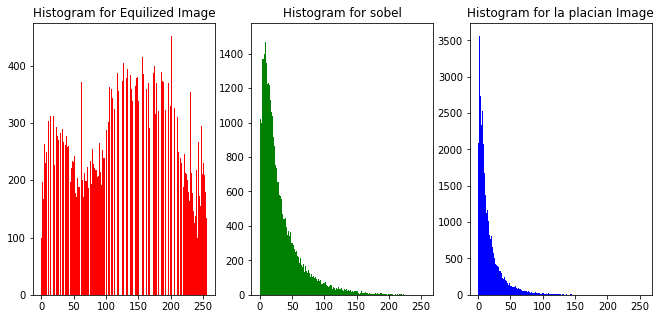

In [72]:
X_train, y_train = load_and_process_images(train_dataset)
X_test, y_test = load_and_process_images(test_dataset)

def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model()

In [73]:
model.summary() 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 222, 222, 32)      320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 52, 52, 128)      

In [74]:
history = model.fit(X_train, y_train, epochs=20, validation_split=0.1) 

Epoch 1/20
229/229 [==============================] - 7s 28ms/step - loss: 6.5175 - accuracy: 0.5875 - val_loss: 0.6799 - val_accuracy: 0.5517
Epoch 2/20
229/229 [==============================] - 6s 27ms/step - loss: 0.5374 - accuracy: 0.7087 - val_loss: 0.5578 - val_accuracy: 0.8461
Epoch 3/20
229/229 [==============================] - 6s 27ms/step - loss: 0.4422 - accuracy: 0.7778 - val_loss: 0.4027 - val_accuracy: 0.9310
Epoch 4/20
229/229 [==============================] - 6s 27ms/step - loss: 0.3540 - accuracy: 0.8341 - val_loss: 0.2792 - val_accuracy: 0.9557
Epoch 5/20
229/229 [==============================] - 6s 27ms/step - loss: 0.3160 - accuracy: 0.8553 - val_loss: 0.2734 - val_accuracy: 0.9421
Epoch 6/20
229/229 [==============================] - 6s 27ms/step - loss: 0.2740 - accuracy: 0.8760 - val_loss: 0.2695 - val_accuracy: 0.9470
Epoch 7/20
229/229 [==============================] - 6s 27ms/step - loss: 0.2369 - accuracy: 0.8925 - val_loss: 0.2438 - val_accuracy: 0.9384

In [75]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

29/29 [==============================] - 0s 8ms/step - loss: 1.2602 - accuracy: 0.8033
Test Loss: 1.2602182626724243
Test Accuracy: 0.8033333420753479


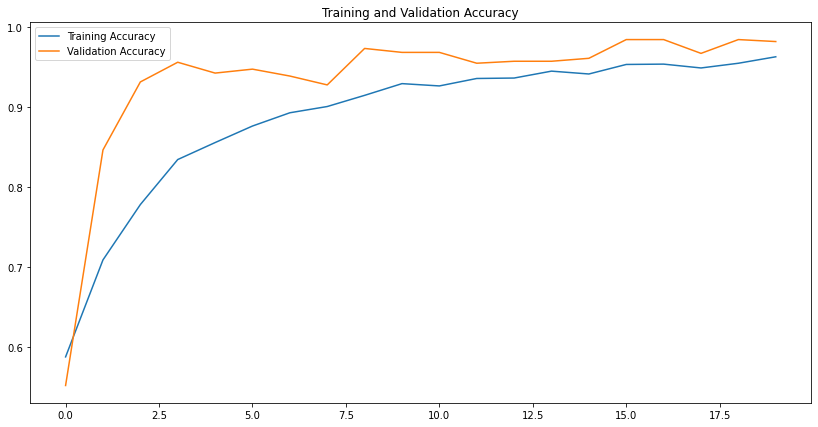

In [76]:
plt.figure(figsize=(14, 7))
plt.plot(history.history['accuracy'], label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.legend(loc='upper left')
plt.show() 

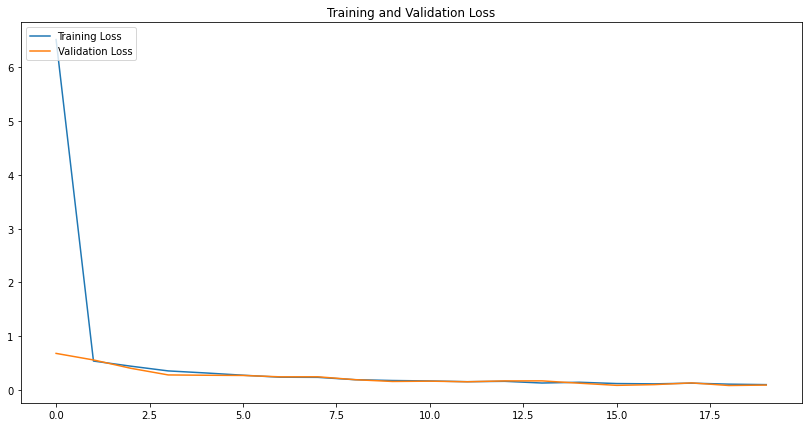

In [77]:
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title('Training and Validation Loss')
plt.legend(loc='upper left')
plt.show()